In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
import cellpose
from cellpose import models, io, core, dynamics
import time
from sklearn.model_selection import train_test_split
from statistics import mean
from u_net import UNet
import torch
import torch.nn as nn
import torch.nn.functional as F

#import data function
def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        files = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in files]
    
    return files
    
def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

#get cellpose predictions
def get_cellpose_predictions(model,images,binary=True):
    logger = io.logger_setup()
    cellprobs = []
    for i in range(len(images)):
        print(i)
        image = images[i]
        masks, flows, styles = model.eval(image, batch_size=1, channels=[0,0], diameter=model.diam_labels)
        cellprobs.append(flows[2])
    if binary:
        predictions = [np.where(mask>0,1,0) for mask in predictions]
    return cellprobs

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, activation_fn, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = activation_fn(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        inputs_binary = torch.where(inputs>0.5,1.0,0.0)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  

        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

def train_epoch(model, train_loader, test_loader, loss_fn, activation_fn, optimiser):
    model.train()

    #get train loss
    #total_train_loss_per_epoch = 0
    for i, (x, y) in enumerate(train_loader):
        #x = x.copy()
        #y = y.copy()
        #print(i)
        #x = x.type(torch.float32)
        #y = y.type(torch.float32)
        (x,y) = (x.to('cuda:0'), y.to('cuda:0')) # sending the data to the device (cpu or GPU)

        x = x.unsqueeze(1)
        pred = model(x)# make a prediction
        #sigmoid the outputs
        pred = activation_fn(pred)
        
        y = torch.unsqueeze(y,1)
        loss = loss_fn(pred, y) # calculate the loss of that prediction
    
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters

        
        #total_train_loss_per_epoch += loss.detach().item()

    #total_train_loss_per_epoch /= len(train_loader)
   
    #get test loss
    #total_test_loss_per_epoch = 0
    total_loss = 0
    with torch.no_grad():
        for images, cellprobs in test_loader:
            #images = images.copy()
            #cellprobs = cellprobs.copy()
            
            images = images.to('cuda:0')
            cellprobs = cellprobs.to('cuda:0')

            images = torch.unsqueeze(images,1)
            cellprobs = torch.unsqueeze(cellprobs,1)
            #cellprobs = cellprobs.to(torch.float32)
            outputs = model(images)
            #sigmoid the outputs
            outputs = activation_fn(outputs)

            #outputs = activation_fn(outputs)
            loss = loss_fn(outputs, cellprobs)
            total_loss += loss
            #total_test_loss_per_epoch += loss.item()

            #calculate dice score
            #outputs = activation_fn(outputs)
            #outputs = torch.where(outputs>0.5,1.0,0.0)
            #outputs = outputs.view(-1)
            #cellprobs = cellprobs.view(-1)
            #intersection = (outputs * cellprobs).sum()  
            #dice = (2.*intersection+1)/(outputs.sum() + cellprobs.sum()+1)  
            #total_dice += dice
            
    #total_test_loss_per_epoch /= len(test_loader)
    #total_dice /= len(test_loader)
    #total_dice = total_dice.item()
    return total_loss.item()/len(test_loader)

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import the 02 images and masks
images, masks = get_data("c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DL-HeLa/', set = '0102',normalise_images=True)
#images, masks = get_data("/Users/rehanzuberi/Downloads/distillCellSegTrack/" + 'datasets/Fluo-N2DL-HeLa/',num_imgs=92)
#split the images and masks into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)
print('split data')

#make the cellpose model predict on the X_train and X_test images
cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model="c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\cellpose_trained_model_GOWT1_2")
y_train_cp = get_cellpose_predictions(cellpose_model,X_train,binary=False)
y_test_cp = get_cellpose_predictions(cellpose_model,X_test,binary=False)
print('got cellpose predictions')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets/Fluo-N2DH-HeLa/01/'

In [1057]:
#sigmoid the cellpose predictions
y_train_cp = [(cellprob-np.min(cellprob))/(np.max(cellprob)-np.min(cellprob)) for cellprob in y_train_cp]
y_test_cp = [(cellprob-np.min(cellprob))/(np.max(cellprob)-np.min(cellprob)) for cellprob in y_test_cp]

In [1066]:
X_train[0].shape

(1024, 1024)

In [1119]:
import numpy as np

def split_image(img):
    # Check if the input array is of size 1280x1280
    if img.shape != (1024, 1024):
        print("Error: Input array is not of size 1280x1280")
        return
    
    # Split the input array into smaller arrays of size 256x256
    sub_images = []
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            sub_img = img[i:i+256, j:j+256]
            sub_images.append(sub_img)
            
    return sub_images

def combine_images(sub_images):
    # Check if the input list contains 16 smaller arrays
    if len(sub_images) != 16:
        print("Error: Input list does not contain 16 smaller arrays")
        return
    
    # Create a NumPy array of size 1024x1024 to store the combined image
    img = np.zeros((1024, 1024))
    
    # Combine the smaller arrays into the larger image
    k = 0
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            img[i:i+256, j:j+256] = sub_images[k]
            k += 1
            
    return img

In [1185]:
#separate the images and masks into splits of size 256x256

X_train_split = []
for image in X_train:
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            sub_img = image[i:i+256, j:j+256]
            X_train_split.append(sub_img)

X_test_split = []
for image in X_test:
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            sub_img = image[i:i+256, j:j+256]
            X_test_split.append(sub_img)

y_train_split = []
for mask in y_train_cp:
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            sub_mask = mask[i:i+256, j:j+256]
            y_train_split.append(sub_mask)

y_test_split = []
for mask in y_test_cp:
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            sub_mask = mask[i:i+256, j:j+256]
            y_test_split.append(sub_mask)


In [1190]:
X_train_split_rot = []
y_train_cp_split_rot = []
for i in range(len(X_train_torch)):
    for j in range(4):
        X_train_split_rot.append(np.rot90(X_train_split[i],j))
        y_train_cp_split_rot.append(np.rot90(y_train_split[i],j))

In [1192]:
print(len(y_train_cp_split_rot))

9408


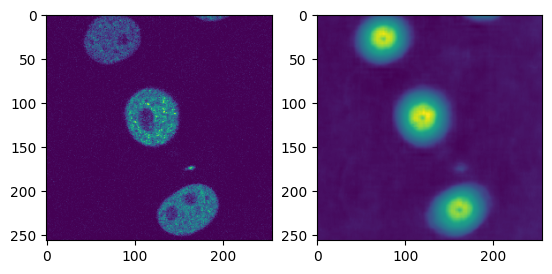

In [1209]:
index = 104
plt.subplot(1,2,1)
plt.imshow(X_train_split_rot[index])
plt.subplot(1,2,2)
plt.imshow(y_train_cp_split_rot[index])
plt.show()

In [1212]:
#train the modelX_train_torch = [torch.from_numpy(np.array(X_train[i])) for i in range(len(X_train))]

from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, image, mask):
        self.image = image
        self.mask = mask

    def __len__(self):
        return len(self.mask)

    def __getitem__(self, idx):
        img = self.image[idx]
        label = self.mask[idx]
        return img, label

X_train_torch = [torch.from_numpy(np.array(X_train_split_rot[i])) for i in range(len(X_train_split_rot))]
y_train_cp_torch = [torch.from_numpy(np.array(y_train_cp_split_rot[i])).type(torch.float32) for i in range(len(y_train_cp_split_rot))]
X_test_torch = [torch.from_numpy(np.array(X_test_split[i])) for i in range(len(X_test_split))]
y_test_cp_torch = [torch.from_numpy(np.array(y_test_split[i])).type(torch.float32) for i in range(len(y_test_split))]
train_dataset = ImageDataset(X_train_torch, y_train_cp_torch)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = ImageDataset(X_test_torch, y_test_cp_torch)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [1213]:
print(len(X_train_torch))
print(len(X_test_torch))
print(len(y_train_cp_torch))
print(len(y_test_cp_torch))

9408
592
9408
592


In [1178]:
#for each image in X_train_torch and each mask in y_train_cp_torch, rotate them 90, 180, and 270 degrees and add them to the training set


In [1180]:
print(len(y_train_cp_torch_rot))

9408


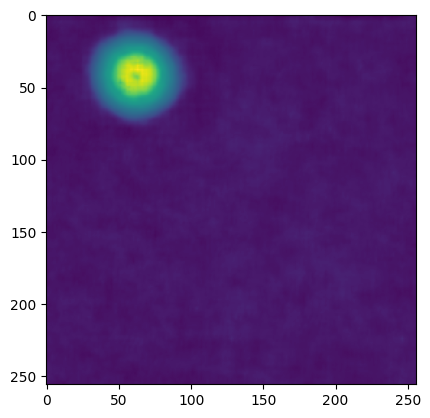

In [1115]:
plt.imshow(y_test_cp_torch[2])

In [ ]:
#do segmentations on 256x256 like cellpose

#need to separate image and reconstruct

#then we can even add rotations

In [1223]:
#model
model = UNet()
model = model.to('cuda:0')

#model configurations
#loss_fn = DiceBCELoss()
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
#BCEwithlogitsloss
print('training')
dices_on_GPU = []
for epoch in range(8):
    start_time = time.time()
    loss = train_epoch(model, train_loader, test_loader, loss_fn, torch.sigmoid, optimiser)
    print('epoch: ', epoch, 'test loss', loss, 'time: ', time.time()-start_time)
    dices_on_GPU.append(dice)

training
epoch:  0 test loss 0.0033958417338293954 time:  34.983773708343506
epoch:  1 test loss 0.002813875675201416 time:  35.274030685424805
epoch:  2 test loss 0.0028962625845058544 time:  33.63518929481506
epoch:  3 test loss 0.002972551898376362 time:  33.80522918701172
epoch:  4 test loss 0.0027272135422036453 time:  34.7273473739624
epoch:  5 test loss 0.002757257706410176 time:  36.377203941345215
epoch:  6 test loss 0.002703611512441893 time:  36.136916160583496
epoch:  7 test loss 0.0026557558291667215 time:  36.20290422439575


In [1220]:
torch.save(model.state_dict(), 'c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\distillation_model_GOWT1_4')

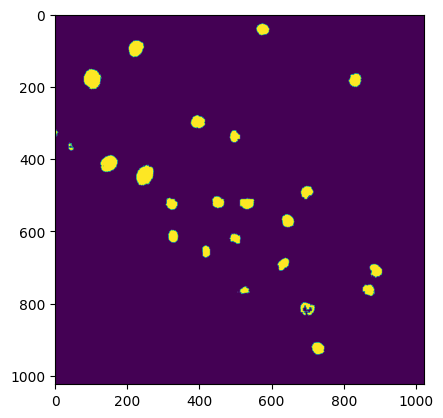

In [1219]:


def get_prediction(image, model):
    splitted = split_image(image)
    predictions = []
    for split in splitted:
        split = torch.from_numpy(split)
        split = split.unsqueeze(0)
        split = split.unsqueeze(0)
        split = split.to('cuda:0')
        prediction = model(split)
        prediction = prediction.squeeze(0)
        prediction = prediction.squeeze(0)
        predictions.append(prediction.cpu().detach().numpy())
    combined_prediction = combine_images(predictions)
    return combined_prediction

combined_image = combine_images(X_test_torch[0:16])
combined_prediction = get_prediction(combined_image,model)

prediction = torch.sigmoid(torch.from_numpy(combined_prediction))
prediction = np.where(prediction>0.5,1,0)

plt.imshow(prediction)

In [1215]:
#recombine all split test images
combined_images = []
for i in range(0, len(X_test_torch), 16):
    combined_image = combine_images(X_test_torch[i:i+16])
    combined_images.append(combined_image)
#recombine all split test masks
combined_masks = []
for i in range(0, len(y_test_cp_torch), 16):
    combined_mask = combine_images(y_test_cp_torch[i:i+16])
    combined_mask = np.where(combined_mask>0.5,1,0)
    combined_masks.append(combined_mask)

#get all predictions on test set
predictions = []
for image in combined_images:
    prediction = get_prediction(image, model)
    prediction = torch.sigmoid(torch.from_numpy(prediction))
    prediction = np.where(prediction>0.5,1,0)
    #prediction = prediction.numpy()
    predictions.append(prediction)

#calculate dice score
dices = get_dice(predictions, combined_masks,return_list=True)
print('mean dice score: ', np.mean(dices))
iou = get_IoU(predictions, combined_masks, return_list=True)
print('mean iou score: ', np.mean(iou))

mean dice score:  0.8751226724820022
mean iou score:  0.7786159100537401


In [1173]:
test_image = combine_images(X_test_torch[0:16])
test_mask = np.where(combine_images(y_test_cp_torch[0:16])>0.5,1,0)
test_prediction = np.where(get_prediction(test_image, model)>0.5,1,0)


print(np.unique(test_mask))
print(np.unique(test_prediction))
get_dice(test_mask, test_prediction)

[0 1]
[0 1]


C:\Users\rz200\AppData\Local\Temp\ipykernel_34100\2030660786.py:15: RuntimeWarning: invalid value encountered in scalar divide
  dice = (2*intersection)/(predicted_masks[i].sum() + gt_masks[i].sum())


nan

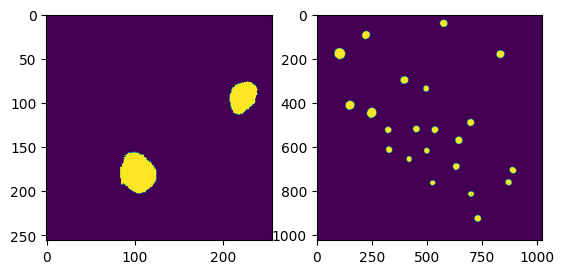

In [1117]:
distill_predictions = model(torch.unsqueeze(torch.unsqueeze(X_test_torch[0],0),0).to('cuda:0'))

plt.subplot(1,2,1)
plt.imshow(torch.squeeze(distill_predictions.cpu().detach()).numpy()>0.5)
plt.subplot(1,2,2)
plt.imshow(y_test_cp[0]>0.5)
plt.show()

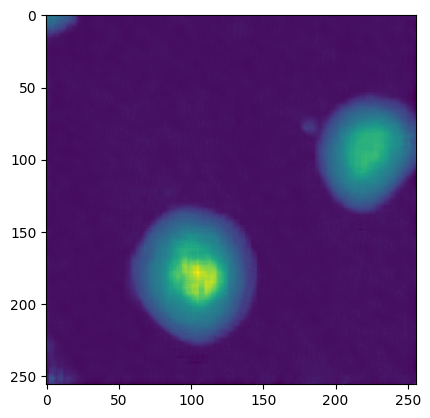

In [1118]:
plt.imshow(distill_predictions[0].cpu().detach().numpy()[0])


In [1036]:
print(distill_predictions[0])

tensor([[[-0.3835, -0.4793, -0.4994,  ..., -0.9403, -0.7966, -0.5660],
         [-0.4901, -0.6644, -0.6977,  ..., -1.5397, -1.2656, -0.8906],
         [-0.5354, -0.7441, -0.7912,  ..., -1.8797, -1.5679, -1.0724],
         ...,
         [-0.8726, -1.3152, -1.5524,  ..., -1.8546, -1.5505, -1.0927],
         [-0.7414, -1.1339, -1.2796,  ..., -1.5318, -1.2756, -0.8853],
         [-0.5377, -0.7280, -0.8469,  ..., -0.9486, -0.8282, -0.6040]]],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [1037]:
def get_IoU(predicted_masks,gt_masks, return_list=False):
    intersection_unions = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        union = np.logical_or(predicted_masks[i], gt_masks[i]).sum()
        intersection_unions.append(intersection/union)
    if return_list:
        return intersection_unions
    return mean(intersection_unions)

def get_dice(predicted_masks,gt_masks, return_list=False):
    dices = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        dice = (2*intersection)/(predicted_masks[i].sum() + gt_masks[i].sum())
        dices.append(dice)
    if return_list:
        return dices
    return mean(dices)

In [1038]:
distill_predictions = []
for i in range(len(X_test_torch)):
    pred = model(torch.unsqueeze(torch.unsqueeze(X_test_torch[i],0),0).to('cuda:0'))
    #pass the pred through a sigmoid
    #pred = torch.nn.Sigmoid()(pred)
    #convert to numpy
    pred = pred.cpu().detach().numpy()
    #sigmoid the pred
    pred = 1/(1+np.exp(-pred))
    pred = np.where(pred>0.5,1,0)
    distill_predictions.append(pred)

y_test_cp_cpu = []
for image in y_test_cp:
    y_test_cp_cpu.append(np.where(image>0.5,1,0))

dice = get_dice(distill_predictions,y_test_cp_cpu)
iou = get_IoU(distill_predictions,y_test_cp_cpu)
print('dice: ', dice, 'iou: ', iou)

dice:  0.7993699962921059 iou:  0.6679292268549865


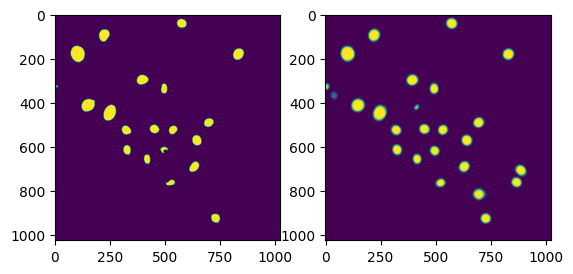

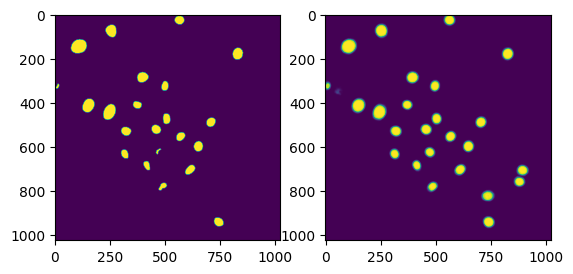

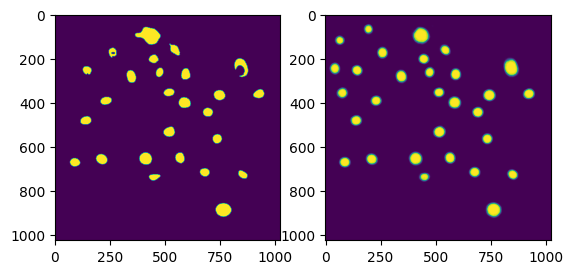

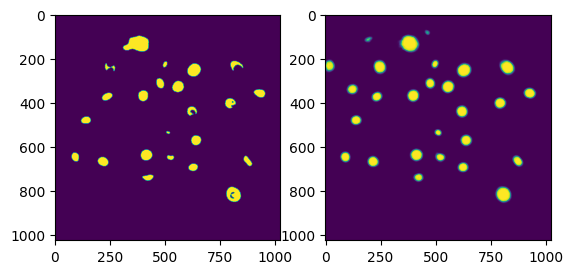

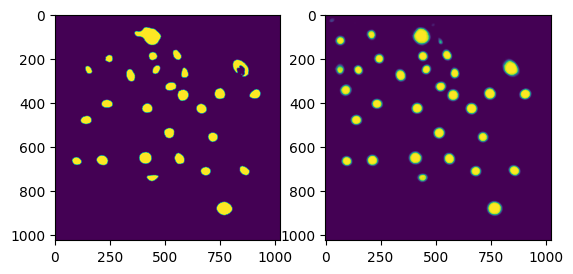

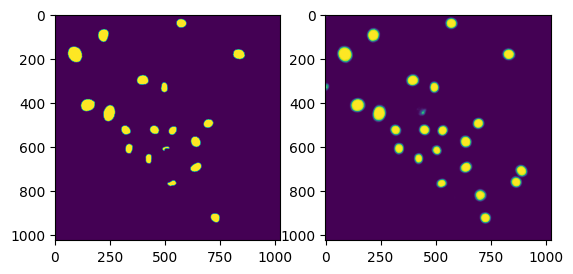

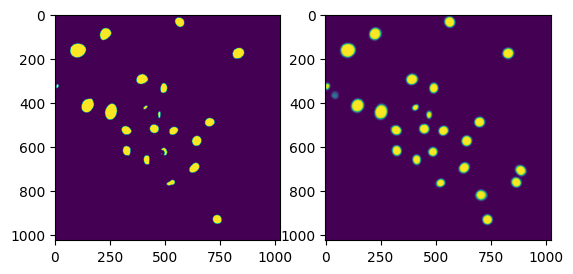

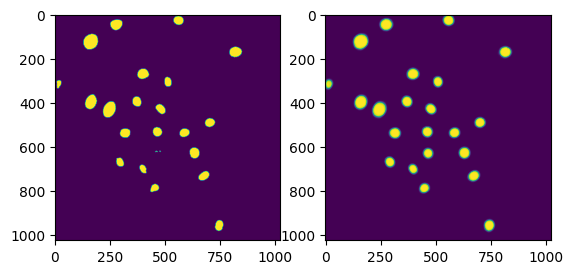

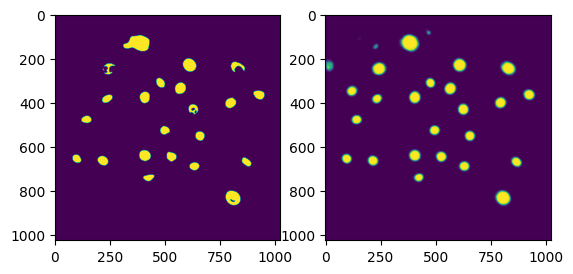

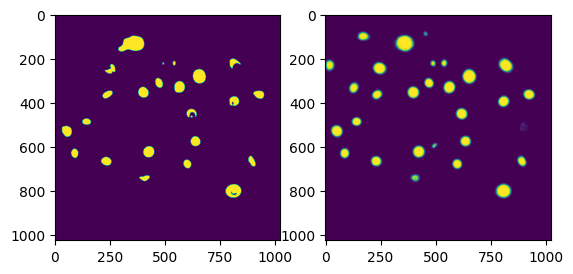

In [930]:
for i in range(10):
    plt.subplot(1,2,1)
    plt.imshow(distill_predictions[i])
    plt.subplot(1,2,2)
    plt.imshow(y_test_cp_cpu[i])
    plt.show()

[-10.183781  -10.0810795 -10.047833  ...  12.548185   12.554702
  12.632153 ]
(256, 256)


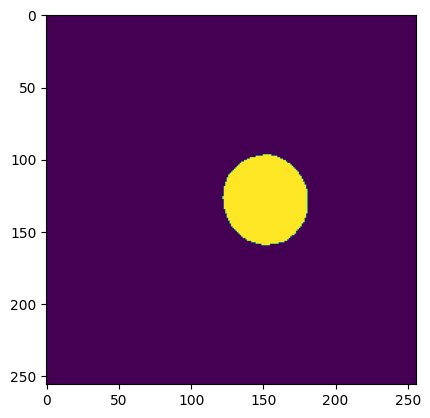

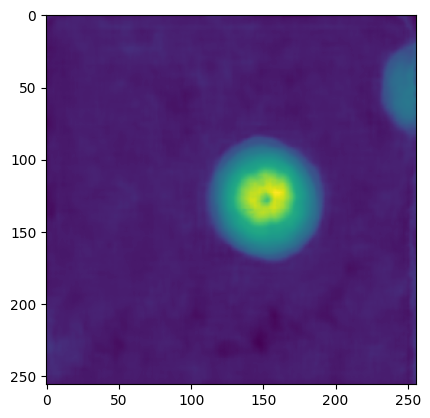

[3.7776685e-05 4.1862451e-05 4.3277545e-05 ... 9.9999630e-01 9.9999642e-01
 9.9999678e-01]


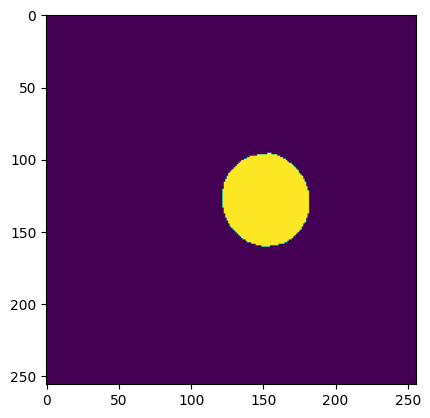

In [865]:
image = X_train[0][0:256,0:256]

masks, flows, styles = cellpose_model.eval(image, batch_size=1, channels=[0,0], diameter=cellpose_model.diam_labels)
cellprob_1 = flows[2]


print(np.unique(cellprob_1_sig))
plt.imshow(cellprob_1_sig>0.5)
plt.show()

In [ ]:
yf, style = cellpose_model.net(img)

In [44]:
print(X_train[0][0:256,0:256].shape)
print(np.tile(X_train[0][0:256,0:256], (2,1, 1)).shape)

(256, 256)
(2, 256, 256)


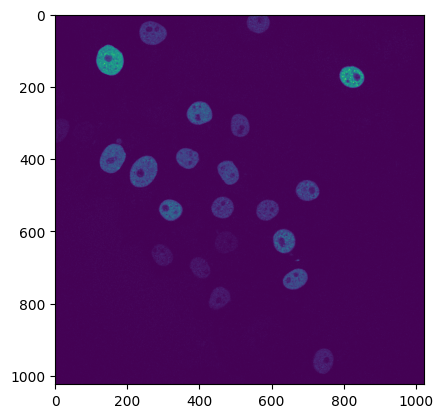

In [39]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

256
(3, 256, 256)


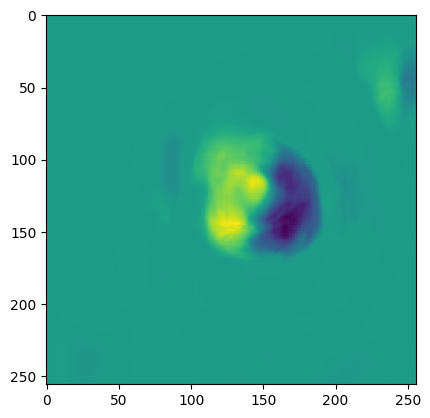

In [126]:
output = cellpose_model.net.forward(torch.from_numpy( np.tile(X_train[0][0:256,0:256], (2,1, 1)) ).unsqueeze(0).to('cuda:0') .float())
print(output[0].shape[-1])
output = output[0].cpu().detach().numpy()[0]
print(output.shape)
plt.imshow(output[1,:,:])

In [235]:
import cv2

def resize_image(img0, Ly=None, Lx=None, rsz=None, interpolation=cv2.INTER_LINEAR, no_channels=False):
    """ resize image for computing flows / unresize for computing dynamics
    Parameters
    -------------
    img0: ND-array
        image of size [Y x X x nchan] or [Lz x Y x X x nchan] or [Lz x Y x X]
    Ly: int, optional
    Lx: int, optional
    rsz: float, optional
        resize coefficient(s) for image; if Ly is None then rsz is used
    interpolation: cv2 interp method (optional, default cv2.INTER_LINEAR)
    Returns
    --------------
    imgs: ND-array 
        image of size [Ly x Lx x nchan] or [Lz x Ly x Lx x nchan]
    """
    if Ly is None and rsz is None:
        error_message = 'must give size to resize to or factor to use for resizing'
        transforms_logger.critical(error_message)
        raise ValueError(error_message)

    if Ly is None:
        # determine Ly and Lx using rsz
        if not isinstance(rsz, list) and not isinstance(rsz, np.ndarray):
            rsz = [rsz, rsz]
        if no_channels:
            Ly = int(img0.shape[-2] * rsz[-2])
            Lx = int(img0.shape[-1] * rsz[-1])
        else:
            Ly = int(img0.shape[-3] * rsz[-2])
            Lx = int(img0.shape[-2] * rsz[-1])
    
    # no_channels useful for z-stacks, sot he third dimension is not treated as a channel
    # but if this is called for grayscale images, they first become [Ly,Lx,2] so ndim=3 but 
    if (img0.ndim>2 and no_channels) or (img0.ndim==4 and not no_channels):
        if Ly==0 or Lx==0:
            raise ValueError('anisotropy too high / low -- not enough pixels to resize to ratio')
        if no_channels:
            imgs = np.zeros((img0.shape[0], Ly, Lx), np.float32)
        else:
            imgs = np.zeros((img0.shape[0], Ly, Lx, img0.shape[-1]), np.float32)
        for i,img in enumerate(img0):
            imgs[i] = cv2.resize(img, (Lx, Ly), interpolation=interpolation)
    else:
        imgs = cv2.resize(img0, (Lx, Ly), interpolation=interpolation)
    return imgs

In [263]:
def convert_image(x, channels, channel_axis=None, z_axis=None,
                  do_3D=False, normalize=True, invert=False,
                  nchan=2):
    """ return image with z first, channels last and normalized intensities """

    # check if image is a torch array instead of numpy array
    # converts torch to numpy
    if torch.is_tensor(x):
        transforms_logger.warning('torch array used as input, converting to numpy')
        x = x.cpu().numpy()
    
    # squeeze image, and if channel_axis or z_axis given, transpose image
    if x.ndim > 3:
        to_squeeze = np.array([int(isq) for isq,s in enumerate(x.shape) if s==1])
        # remove channel axis if number of channels is 1
        if len(to_squeeze) > 0: 
            channel_axis = update_axis(channel_axis, to_squeeze, x.ndim) if channel_axis is not None else channel_axis
            z_axis = update_axis(z_axis, to_squeeze, x.ndim) if z_axis is not None else z_axis
        x = x.squeeze()

    # put z axis first
    if z_axis is not None and x.ndim > 2:
        x = move_axis(x, m_axis=z_axis, first=True)
        if channel_axis is not None:
            channel_axis += 1
        if x.ndim==3:
            x = x[...,np.newaxis]
        
    # put channel axis last
    if channel_axis is not None and x.ndim > 2:
        x = move_axis(x, m_axis=channel_axis, first=False)
    elif x.ndim == 2:
        x = x[:,:,np.newaxis]

    if do_3D :
        if x.ndim < 3:
            transforms_logger.critical('ERROR: cannot process 2D images in 3D mode')
            raise ValueError('ERROR: cannot process 2D images in 3D mode') 
        elif x.ndim<4:
            x = x[...,np.newaxis]

    if channel_axis is None:
        x = move_min_dim(x)
        
    if x.ndim > 3:
        transforms_logger.info('multi-stack tiff read in as having %d planes %d channels'%
                (x.shape[0], x.shape[-1]))

    if channels is not None:
        channels = channels[0] if len(channels)==1 else channels
        if len(channels) < 2:
            transforms_logger.critical('ERROR: two channels not specified')
            raise ValueError('ERROR: two channels not specified') 
        x = reshape(x, channels=channels)
        
    else:
        # code above put channels last
        if x.shape[-1] > nchan:
            transforms_logger.warning('WARNING: more than %d channels given, use "channels" input for specifying channels - just using first %d channels to run processing'%(nchan,nchan))
            x = x[...,:nchan]

        if not do_3D and x.ndim>3:
            transforms_logger.critical('ERROR: cannot process 4D images in 2D mode')
            raise ValueError('ERROR: cannot process 4D images in 2D mode')
            
        if x.shape[-1] < nchan:
            x = np.concatenate((x, 
                                np.tile(np.zeros_like(x), (1,1,nchan-1))), 
                                axis=-1)
            
    if normalize or invert:
        x = normalize_img(x, invert=invert)
        
    return x

In [429]:
def flow_error(maski, dP_net, use_gpu=False, device=None):
    """ error in flows from predicted masks vs flows predicted by network run on image
    This function serves to benchmark the quality of masks, it works as follows
    1. The predicted masks are used to create a flow diagram
    2. The mask-flows are compared to the flows that the network predicted
    If there is a discrepancy between the flows, it suggests that the mask is incorrect.
    Masks with flow_errors greater than 0.4 are discarded by default. Setting can be
    changed in Cellpose.eval or CellposeModel.eval.
    Parameters
    ------------
    
    maski: ND-array (int) 
        masks produced from running dynamics on dP_net, 
        where 0=NO masks; 1,2... are mask labels
    dP_net: ND-array (float) 
        ND flows where dP_net.shape[1:] = maski.shape
    Returns
    ------------
    flow_errors: float array with length maski.max()
        mean squared error between predicted flows and flows from masks
    dP_masks: ND-array (float)
        ND flows produced from the predicted masks
    
    """
    if dP_net.shape[1:] != maski.shape:
        print('ERROR: net flow is not same size as predicted masks')
        return

    # flows predicted from estimated masks
    dP_masks = masks_to_flows(maski, use_gpu=use_gpu, device=device)
    # difference between predicted flows vs mask flows
    flow_errors=np.zeros(maski.max())
    for i in range(dP_masks.shape[0]):
        flow_errors += mean((dP_masks[i] - dP_net[i]/5.)**2, maski,
                            index=np.arange(1, maski.max()+1))

    return flow_errors, dP_masks

In [423]:
def remove_bad_flow_masks(masks, flows, threshold=0.4, use_gpu=False, device=None):
    """ remove masks which have inconsistent flows 
    
    Uses metrics.flow_error to compute flows from predicted masks 
    and compare flows to predicted flows from network. Discards 
    masks with flow errors greater than the threshold.
    Parameters
    ----------------
    masks: int, 2D or 3D array
        labelled masks, 0=NO masks; 1,2,...=mask labels,
        size [Ly x Lx] or [Lz x Ly x Lx]
    flows: float, 3D or 4D array
        flows [axis x Ly x Lx] or [axis x Lz x Ly x Lx]
    threshold: float (optional, default 0.4)
        masks with flow error greater than threshold are discarded.
    Returns
    ---------------
    masks: int, 2D or 3D array
        masks with inconsistent flow masks removed, 
        0=NO masks; 1,2,...=mask labels,
        size [Ly x Lx] or [Lz x Ly x Lx]
    
    """
    if masks.size > 10000*10000:
        
        major_version, minor_version, _ = torch.__version__.split(".")
        
        if major_version == "1" and int(minor_version) < 10:
            # for PyTorch version lower than 1.10
            def mem_info():
                total_mem = torch.cuda.get_device_properties(0).total_memory
                used_mem = torch.cuda.memory_allocated()
                return total_mem, used_mem
        else:
            # for PyTorch version 1.10 and above
            def mem_info():
                total_mem, used_mem = torch.cuda.mem_get_info()
                return total_mem, used_mem
        
        if masks.size * 20 > mem_info()[0]:
            dynamics_logger.warning('WARNING: image is very large, not using gpu to compute flows from masks for QC step flow_threshold')
            dynamics_logger.info('turn off QC step with flow_threshold=0 if too slow')
        use_gpu = False

    merrors, _ = flow_error(masks, flows, use_gpu, device)
    badi = 1+(merrors>threshold).nonzero()[0]
    masks[np.isin(masks, badi)] = 0
    return masks

In [432]:
def masks_to_flows_gpu(masks, device=None):
    """ convert masks to flows using diffusion from center pixel
    Center of masks where diffusion starts is defined using COM
    Parameters
    -------------
    masks: int, 2D or 3D array
        labelled masks 0=NO masks; 1,2,...=mask labels
    Returns
    -------------
    mu: float, 3D or 4D array 
        flows in Y = mu[-2], flows in X = mu[-1].
        if masks are 3D, flows in Z = mu[0].
    mu_c: float, 2D or 3D array
        for each pixel, the distance to the center of the mask 
        in which it resides 
    """
    if device is None:
        device = torch.device('cuda')

    
    Ly0,Lx0 = masks.shape
    Ly, Lx = Ly0+2, Lx0+2

    masks_padded = np.zeros((Ly, Lx), np.int64)
    masks_padded[1:-1, 1:-1] = masks

    # get mask pixel neighbors
    y, x = np.nonzero(masks_padded)
    neighborsY = np.stack((y, y-1, y+1, 
                           y, y, y-1, 
                           y-1, y+1, y+1), axis=0)
    neighborsX = np.stack((x, x, x, 
                           x-1, x+1, x-1, 
                           x+1, x-1, x+1), axis=0)
    neighbors = np.stack((neighborsY, neighborsX), axis=-1)

    # get mask centers
    slices = find_objects(masks)
    
    centers = np.zeros((masks.max(), 2), 'int')
    for i,si in enumerate(slices):
        if si is not None:
            sr,sc = si
            ly, lx = sr.stop - sr.start + 1, sc.stop - sc.start + 1
            yi,xi = np.nonzero(masks[sr, sc] == (i+1))
            yi = yi.astype(np.int32) + 1 # add padding
            xi = xi.astype(np.int32) + 1 # add padding
            ymed = np.median(yi)
            xmed = np.median(xi)
            imin = np.argmin((xi-xmed)**2 + (yi-ymed)**2)
            xmed = xi[imin]
            ymed = yi[imin]
            centers[i,0] = ymed + sr.start 
            centers[i,1] = xmed + sc.start

    # get neighbor validator (not all neighbors are in same mask)
    neighbor_masks = masks_padded[neighbors[:,:,0], neighbors[:,:,1]]
    isneighbor = neighbor_masks == neighbor_masks[0]
    ext = np.array([[sr.stop - sr.start + 1, sc.stop - sc.start + 1] for sr, sc in slices])
    n_iter = 2 * (ext.sum(axis=1)).max()
    # run diffusion
    mu = _extend_centers_gpu(neighbors, centers, isneighbor, Ly, Lx, 
                             n_iter=n_iter, device=device)

    # normalize
    mu /= (1e-20 + (mu**2).sum(axis=0)**0.5)

    # put into original image
    mu0 = np.zeros((2, Ly0, Lx0))
    mu0[:, y-1, x-1] = mu
    mu_c = np.zeros_like(mu0)
    return mu0, mu_c

In [433]:
def masks_to_flows(masks, use_gpu=False, device=None):
    """ convert masks to flows using diffusion from center pixel
    Center of masks where diffusion starts is defined to be the 
    closest pixel to the median of all pixels that is inside the 
    mask. Result of diffusion is converted into flows by computing
    the gradients of the diffusion density map. 
    Parameters
    -------------
    masks: int, 2D or 3D array
        labelled masks 0=NO masks; 1,2,...=mask labels
    Returns
    -------------
    mu: float, 3D or 4D array 
        flows in Y = mu[-2], flows in X = mu[-1].
        if masks are 3D, flows in Z = mu[0].
    mu_c: float, 2D or 3D array
        for each pixel, the distance to the center of the mask 
        in which it resides 
    """
    if masks.max() == 0:
        dynamics_logger.warning('empty masks!')
        return np.zeros((2, *masks.shape), 'float32')

    if use_gpu:
        if use_gpu and device is None:
            device = torch_GPU
        elif device is None:
            device = torch_CPU
        masks_to_flows_device = masks_to_flows_gpu
    else:
        masks_to_flows_device = masks_to_flows_cpu
        
    if masks.ndim==3:
        Lz, Ly, Lx = masks.shape
        mu = np.zeros((3, Lz, Ly, Lx), np.float32)
        for z in range(Lz):
            mu0 = masks_to_flows_device(masks[z], device=device)[0]
            mu[[1,2], z] += mu0
        for y in range(Ly):
            mu0 = masks_to_flows_device(masks[:,y], device=device)[0]
            mu[[0,2], :, y] += mu0
        for x in range(Lx):
            mu0 = masks_to_flows_device(masks[:,:,x], device=device)[0]
            mu[[0,1], :, :, x] += mu0
        return mu
    elif masks.ndim==2:
        mu, mu_c = masks_to_flows_device(masks, device=device)
        return mu

    else:
        raise ValueError('masks_to_flows only takes 2D or 3D arrays')

In [273]:
x = X_train[0][0:256,0:256]
x = [convert_image(xi, [0,0], do_3D=False, 
                                    normalize=True, invert=False, nchan=1) for xi in x]

NameError: name 'move_min_dim' is not defined

In [328]:
x = np.expand_dims(X_train[0][0:256,0:256],0)
shape = x.shape
nimg = shape[0]
dP = np.zeros((2, nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)
cellprob = np.zeros((nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)

img = np.asarray(np.tile(x, (2,1,1)))
img = torch.from_numpy(img).unsqueeze(0).to('cuda:0').float()

yf, style = cellpose_model.net(img)
yf = yf.squeeze().detach().cpu().numpy()
print(yf.shape)
yf = np.transpose(yf, (1,2,0))
print(yf.shape)
cellprob[0] = yf[:,:,2]
dP[:, 0] = yf[:,:,:2].transpose((2,0,1)) 

print(dP.shape)

(3, 256, 256)
(256, 256, 3)
(2, 1, 256, 256)


In [434]:
outputs = dynamics.compute_masks(dP[:,0], cellprob[0], niter=niter, cellprob_threshold=cellprob_threshold,
                                                         flow_threshold=flow_threshold, interp=interp, resize=resize,
                                                         use_gpu=self.gpu, device=self.device)

NameError: name 'dynamics' is not defined

In [355]:
print(np.unique(cellprob))

[-256.83832 -256.59332 -254.3559  ...  923.3564   925.2566   935.26624]


In [356]:
print(np.any(cellprob))

True


In [359]:
print(cellprob.shape)
print(cellprob.squeeze().shape)

(1, 256, 256)
(256, 256)


In [344]:
#sigmoid cellprob
cellprob_sig = 1/(1+np.exp(-cellprob))

C:\Users\rz200\AppData\Local\Temp\ipykernel_34100\2234213973.py:2: RuntimeWarning: overflow encountered in exp
  cellprob_sig = 1/(1+np.exp(-cellprob))


In [630]:
x = np.expand_dims(X_train[0][0:256,0:256],0)
img = np.asarray(np.tile(x, (2,1,1)))
img = torch.from_numpy(img).unsqueeze(0).to('cuda:0').float()
#masks, styles, dP, cellprob, p = cellpose_model._run_cp(x,normalize=True)
#cp_mask = cellprob > 0
print(img.shape)
yf, style = cellpose_model.net(img)
yf = yf.detach().cpu().numpy().squeeze()
print(yf.shape)
yf = np.transpose(yf, (1,2,0))
print(yf.shape)

torch.Size([1, 2, 256, 256])
(3, 256, 256)
(256, 256, 3)


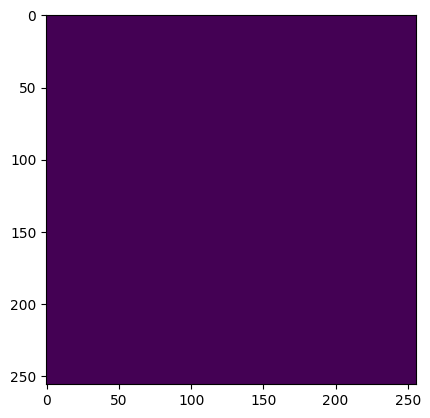

In [641]:
dP = np.zeros((2, 1, int(shape[1]), int(shape[2])), np.float32)
dP[:, 0] = yf[:,:,:2].transpose((2,0,1)) 

cellprob = np.zeros((1, int(shape[1]), int(shape[2])), np.float32)
cellprob[0] = yf[:,:,2]

mask, _ = dynamics.compute_masks(dP[:,0], cellprob[0],cellprob_threshold=0.0, flow_threshold=0.4,niter=200,resize=None,min_size=15)
plt.imshow(mask)

In [642]:
print(yf.shape)

(256, 256, 3)


[-256.83832 -256.59332 -254.3559  ...  923.3564   925.2566   935.26624]


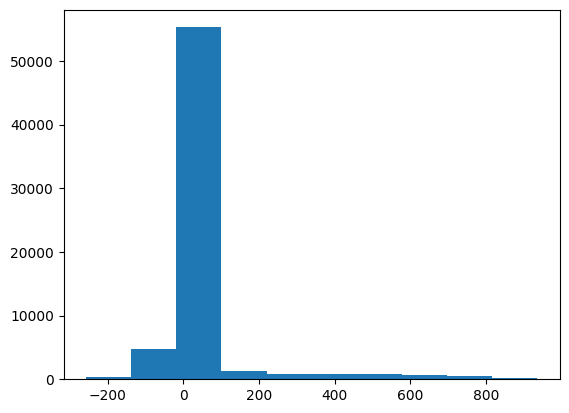

In [721]:
yf, style = cellpose_model.net(img)
yf = yf.detach().cpu().numpy().squeeze()
yf = np.transpose(yf, (1,2,0))
print(np.unique(yf))
plt.hist(yf[:,:,2].flatten(), bins=10); plt.show()

In [724]:
print(yf.shape)

(256, 256, 3)


(array([0, 1]), array([1009358,   39218], dtype=int64))


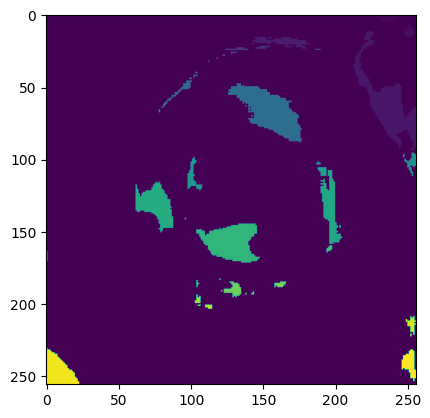

(array([0, 1]), array([1009358,   39218], dtype=int64))


In [836]:
masks = get_masks_unet(yf_sig, cell_threshold=0.1, boundary_threshold=1)
print(np.unique(y_train_cp[0], return_counts=True))
plt.imshow(masks);plt.show()
#plt.imshow(y_train_cp[0][0:256,0:256]);plt.show()
print(np.unique(y_train_cp[0], return_counts=True))

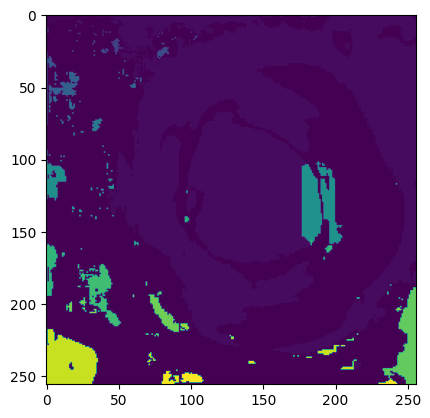

In [728]:
plt.imshow(masks)

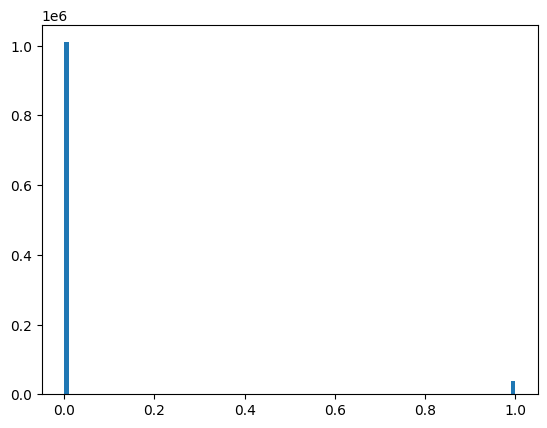

In [682]:
plt.hist(y_train_cp[0].flatten(), bins=100); plt.show()

25.810556
935.26624


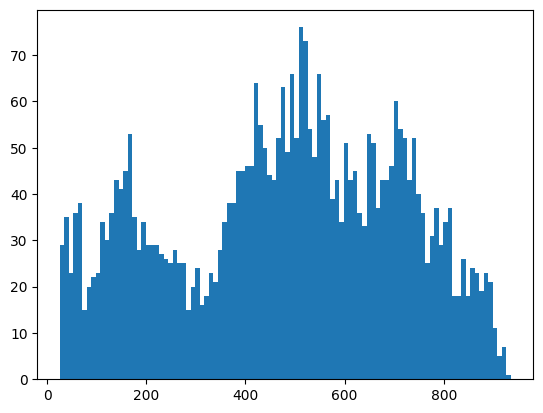

-256.83832
697.31384


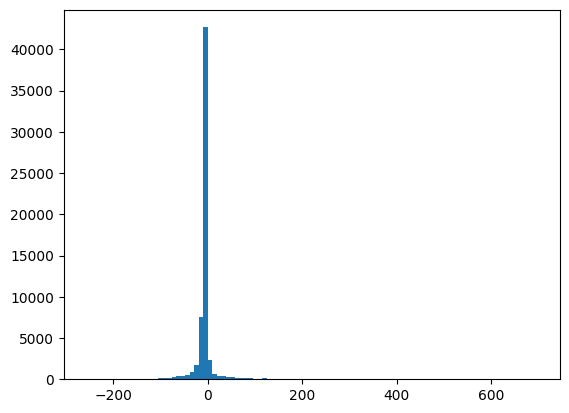

In [695]:
#get the values of the pixels in y_train_cp[0][0:256,0:256] that are greater than 0
vals = yf[:,:,2][y_train_cp[0][0:256,0:256]>0]
print(min(vals))
print(max(vals))
#plot these values
plt.hist(vals.flatten(), bins=100); plt.show()

vals = yf[:,:,2][y_train_cp[0][0:256,0:256]==0]
print(min(vals))
print(max(vals))
plt.hist(vals.flatten(), bins=100); plt.show()

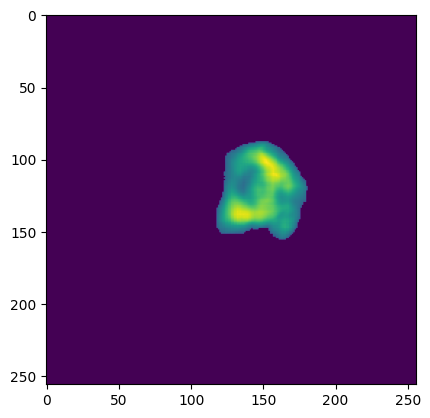

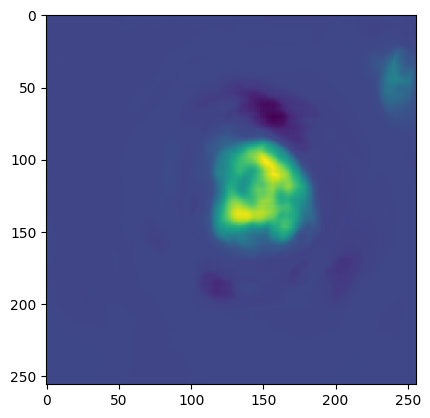

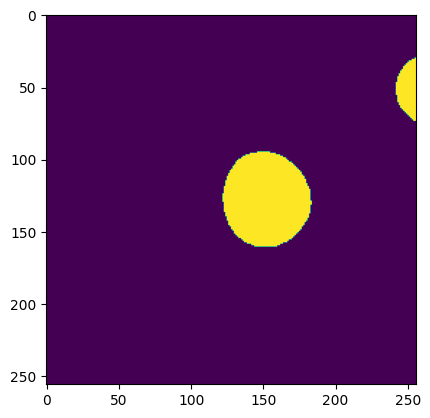

In [711]:
#remove from yf[:,:,2] the values in the range -10 to 10
cellprob_filtered = yf[:,:,2].copy()
cellprob_filtered[(cellprob_filtered>-300) & (cellprob_filtered<300)] = 0

plt.imshow(cellprob_filtered); plt.show()
plt.imshow(yf[:,:,2]); plt.show()

plt.imshow(y_train_cp[0][0:256,0:256]); plt.show()

[-256.83832 -256.59332 -254.3559  ...  923.3564   925.2566   935.26624]


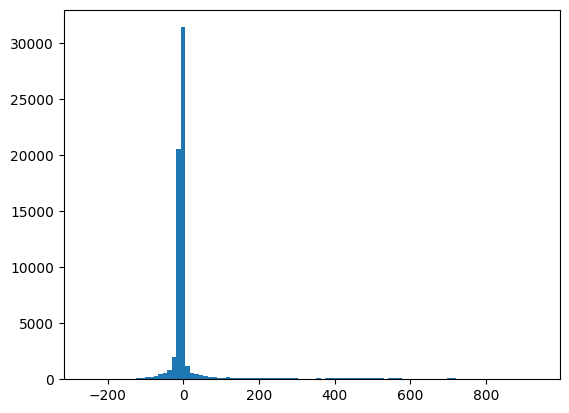

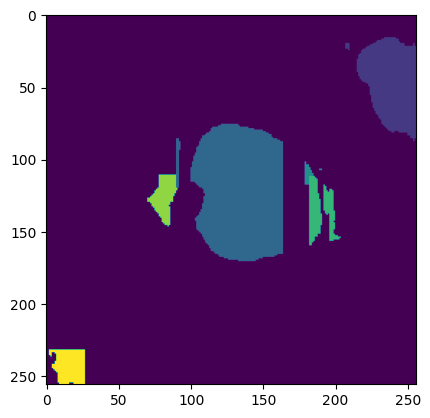

In [679]:
from cellpose import utils

x = np.expand_dims(X_train[0][0:256,0:256],0)
img = np.asarray(np.tile(x, (2,1,1)))
shape = img.shape
img = torch.from_numpy(img).unsqueeze(0).to('cuda:0').float()

yf, style = cellpose_model.net(img)
yf = yf.detach().cpu().numpy().squeeze()
yf = np.transpose(yf, (1,2,0))
print(np.unique(yf))
plt.hist(yf[:,:,2].flatten(), bins=100); plt.show()
mask = utils.get_masks_unet(yf,3,0.4)
mask = utils.fill_holes_and_remove_small_masks(mask, min_size=15)
#mask = transforms.resize_image(mask, shape[-3], shape[-2], interpolation=cv2.INTER_NEAREST)

plt.imshow(mask)

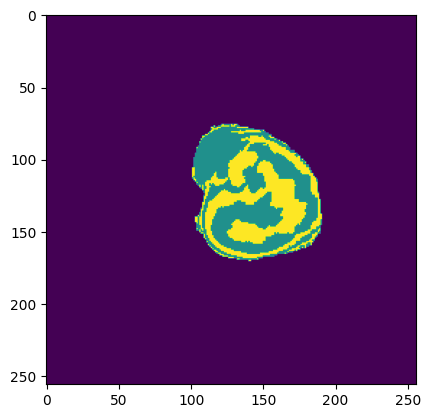

In [537]:
plt.imshow(yf[0,0,:,:].detach().cpu().numpy())

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

[0 1 2]


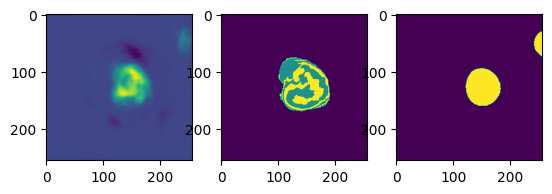

In [610]:
x = np.expand_dims(X_train[0][0:256,0:256],0)
img = np.asarray(np.tile(x, (2,1,1)))
img = torch.from_numpy(img).unsqueeze(0).to('cuda:0').float()

yf, style = cellpose_model.net(img)
yf = yf.detach().cpu().numpy().squeeze()
yf = np.transpose(yf, (1,2,0))

plt.subplot(1,3,1)
plt.imshow(yf[:,:,2])

dP = np.zeros((2, 1, int(shape[1]), int(shape[2])), np.float32)
dP[:, 0] = yf[:,:,:2].transpose((2,0,1)) 

cellprob = np.zeros((1, int(shape[1]), int(shape[2])), np.float32)
cellprob[0] = yf[:,:,2]

mask, _ = dynamics.compute_masks(dP[:,0], cellprob[0],cellprob_threshold=0, flow_threshold=0,niter=200,resize=None,min_size=2500)
print(np.unique(mask))
plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
plt.imshow(y_train_cp[0][0:256,0:256]); plt.show()

(1, 256, 256, 2)


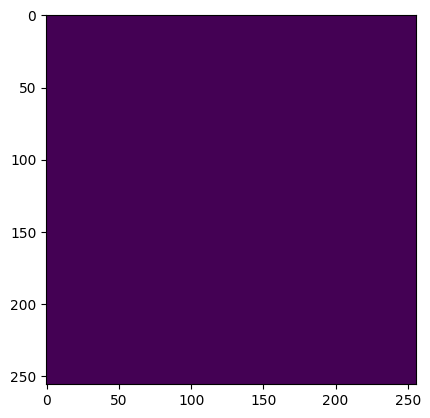

In [629]:
x = X_train[0][0:256,0:256]
img = np.tile(x, (2,1,1))
img = np.expand_dims(img,0)
img = np.transpose(img, (0,2,3,1))
print(img.shape)
masks, styles, dP, cellprob, p = cellpose_model._run_cp(img)

plt.imshow(masks)

In [551]:
def cellprob_to_mask(self, cellprob, yf, rescale=1.0, stitch_threshold=0.0, cellprob_threshold=0.0, flow_threshold=0.4,interp=True):
    niter = 1 / rescale * 200
    masks, p = [], []
    resize = [shape[1], shape[2]]
    iterator = len(cellprob)
    nimg = 1
    dP = np.zeros((2, nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)
    cellprob = np.zeros((nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)
    print(yf.shape)
    cellprob[0] = yf[:,:,2]
    dP[:, 0] = yf[:,:,:2].transpose((2,0,1)) 
    for i in range(1):
        print(i)
        outputs = dynamics.compute_masks(dP[:,i], cellprob[i], niter=niter, cellprob_threshold=cellprob_threshold,
                                                flow_threshold=flow_threshold, interp=interp, resize=resize,
                                                use_gpu=self.gpu, device=self.device)
        print(outputs[1].shape)
        masks.append(outputs[0])
        print(np.unique(masks))
        plt.imshow(masks[0])
        p.append(outputs[1])
        
    masks = np.array(masks)
    p = np.array(p)

    masks, dP, cellprob, p = masks.squeeze(), dP.squeeze(), cellprob.squeeze(), p.squeeze()

cellpose.models.CellposeModel.cellprob_to_mask = cellprob_to_mask

In [540]:
cellprob_exp = np.expand_dims(cellprob, 0)
print(cellprob_exp.shape)

(1, 1, 256, 256)


In [541]:
nimg = 1
dP = np.zeros((2, nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)
cellprob = np.zeros((nimg, int(shape[1]*rescale), int(shape[2]*rescale)), np.float32)
print(yf.shape)
cellprob[0] = yf[:,:,2]
dP[:, 0] = yf[:,:,:2].transpose((2,0,1)) 

(256, 256, 3)


(256, 256, 3)
0
(2, 256, 256)
[0]


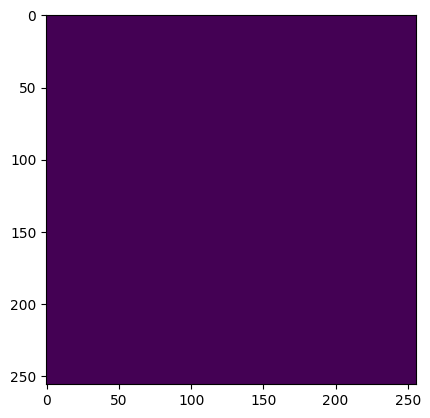

In [552]:
new_mask = cellpose_model.cellprob_to_mask(cellprob_exp, yf)

In [438]:
print(cellprob.shape)

(256, 256)


In [401]:
import fastremap

def get_masks(p, iscell=cp_mask, rpad=20):
    """ create masks using pixel convergence after running dynamics
    
    Makes a histogram of final pixel locations p, initializes masks 
    at peaks of histogram and extends the masks from the peaks so that
    they include all pixels with more than 2 final pixels p. Discards 
    masks with flow errors greater than the threshold. 
    Parameters
    ----------------
    p: float32, 3D or 4D array
        final locations of each pixel after dynamics,
        size [axis x Ly x Lx] or [axis x Lz x Ly x Lx].
    iscell: bool, 2D or 3D array
        if iscell is not None, set pixels that are 
        iscell False to stay in their original location.
    rpad: int (optional, default 20)
        histogram edge padding
    threshold: float (optional, default 0.4)
        masks with flow error greater than threshold are discarded 
        (if flows is not None)
    flows: float, 3D or 4D array (optional, default None)
        flows [axis x Ly x Lx] or [axis x Lz x Ly x Lx]. If flows
        is not None, then masks with inconsistent flows are removed using 
        `remove_bad_flow_masks`.
    Returns
    ---------------
    M0: int, 2D or 3D array
        masks with inconsistent flow masks removed, 
        0=NO masks; 1,2,...=mask labels,
        size [Ly x Lx] or [Lz x Ly x Lx]
    
    """
    
    pflows = []
    edges = []
    shape0 = p.shape[1:]
    dims = len(p)
    if iscell is not None:
        if dims==3:
            inds = np.meshgrid(np.arange(shape0[0]), np.arange(shape0[1]),
                np.arange(shape0[2]), indexing='ij')
        elif dims==2:
            inds = np.meshgrid(np.arange(shape0[0]), np.arange(shape0[1]),
                     indexing='ij')
        for i in range(dims):
            p[i, ~iscell] = inds[i][~iscell]

    for i in range(dims):
        pflows.append(p[i].flatten().astype('int32'))
        edges.append(np.arange(-.5-rpad, shape0[i]+.5+rpad, 1))

    h,_ = np.histogramdd(tuple(pflows), bins=edges)
    hmax = h.copy()
    for i in range(dims):
        hmax = maximum_filter1d(hmax, 5, axis=i)

    seeds = np.nonzero(np.logical_and(h-hmax>-1e-6, h>10))
    Nmax = h[seeds]
    isort = np.argsort(Nmax)[::-1]
    for s in seeds:
        s = s[isort]

    pix = list(np.array(seeds).T)

    shape = h.shape
    if dims==3:
        expand = np.nonzero(np.ones((3,3,3)))
    else:
        expand = np.nonzero(np.ones((3,3)))
    for e in expand:
        e = np.expand_dims(e,1)

    for iter in range(5):
        for k in range(len(pix)):
            if iter==0:
                pix[k] = list(pix[k])
            newpix = []
            iin = []
            for i,e in enumerate(expand):
                epix = e[:,np.newaxis] + np.expand_dims(pix[k][i], 0) - 1
                epix = epix.flatten()
                iin.append(np.logical_and(epix>=0, epix<shape[i]))
                newpix.append(epix)
            iin = np.all(tuple(iin), axis=0)
            for p in newpix:
                p = p[iin]
            newpix = tuple(newpix)
            igood = h[newpix]>2
            for i in range(dims):
                pix[k][i] = newpix[i][igood]
            if iter==4:
                pix[k] = tuple(pix[k])
    
    M = np.zeros(h.shape, np.uint32)
    for k in range(len(pix)):
        M[pix[k]] = 1+k
        
    for i in range(dims):
        pflows[i] = pflows[i] + rpad
    M0 = M[tuple(pflows)]

    # remove big masks
    uniq, counts = fastremap.unique(M0, return_counts=True)
    big = np.prod(shape0) * 0.4
    bigc = uniq[counts > big]
    if len(bigc) > 0 and (len(bigc)>1 or bigc[0]!=0):
        M0 = fastremap.mask(M0, bigc)
    fastremap.renumber(M0, in_place=True) #convenient to guarantee non-skipped labels
    M0 = np.reshape(M0, shape0)
    return M0

In [435]:

recre_masks = get_masks(p,iscell=cp_mask)
mask_no_bad = remove_bad_flow_masks(recre_masks, dP, threshold=0.4, use_gpu=True, device="cuda:0")

NameError: name '_extend_centers_gpu' is not defined

In [417]:
print(np.unique(recre_masks))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


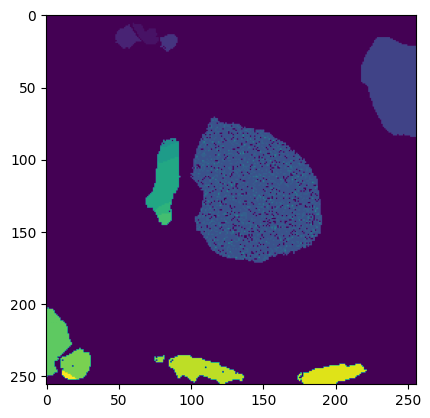

In [415]:
plt.imshow(recre_masks)

In [388]:
#sigmoid cellprob
cellprob_sig = 1/(1+np.exp(-cellprob))

C:\Users\rz200\AppData\Local\Temp\ipykernel_34100\2234213973.py:2: RuntimeWarning: overflow encountered in exp
  cellprob_sig = 1/(1+np.exp(-cellprob))


In [391]:
print(np.unique(cellprob_sig))

[0.0000000e+00 3.2578256e-39 3.2669102e-39 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


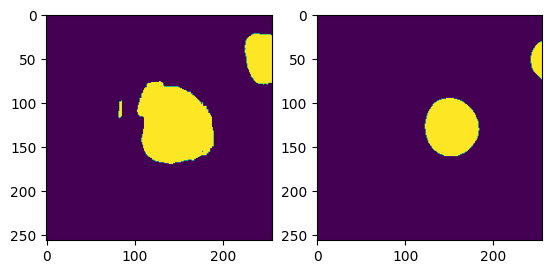

In [416]:
plt.subplot(1,2,1)
plt.imshow(cellprob_sig==1.00)

plt.subplot(1,2,2)
plt.imshow(y_train_cp[0][0:256,0:256])
plt.show()

In [354]:
print(cellprob.shape)

(1, 256, 256)


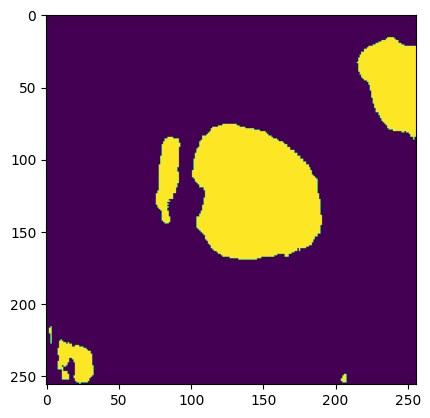

In [353]:
cp_mask = cellprob_sig > 0.8

plt.imshow(cp_mask[0])

#masks = get_masks()

In [331]:
def get_masks(p, iscell=None, rpad=20):
    """ create masks using pixel convergence after running dynamics
    
    Makes a histogram of final pixel locations p, initializes masks 
    at peaks of histogram and extends the masks from the peaks so that
    they include all pixels with more than 2 final pixels p. Discards 
    masks with flow errors greater than the threshold. 
    Parameters
    ----------------
    p: float32, 3D or 4D array
        final locations of each pixel after dynamics,
        size [axis x Ly x Lx] or [axis x Lz x Ly x Lx].
    iscell: bool, 2D or 3D array
        if iscell is not None, set pixels that are 
        iscell False to stay in their original location.
    rpad: int (optional, default 20)
        histogram edge padding
    threshold: float (optional, default 0.4)
        masks with flow error greater than threshold are discarded 
        (if flows is not None)
    flows: float, 3D or 4D array (optional, default None)
        flows [axis x Ly x Lx] or [axis x Lz x Ly x Lx]. If flows
        is not None, then masks with inconsistent flows are removed using 
        `remove_bad_flow_masks`.
    Returns
    ---------------
    M0: int, 2D or 3D array
        masks with inconsistent flow masks removed, 
        0=NO masks; 1,2,...=mask labels,
        size [Ly x Lx] or [Lz x Ly x Lx]
    
    """
    
    pflows = []
    edges = []
    shape0 = p.shape[1:]
    dims = len(p)
    if iscell is not None:
        if dims==3:
            inds = np.meshgrid(np.arange(shape0[0]), np.arange(shape0[1]),
                np.arange(shape0[2]), indexing='ij')
        elif dims==2:
            inds = np.meshgrid(np.arange(shape0[0]), np.arange(shape0[1]),
                     indexing='ij')
        for i in range(dims):
            p[i, ~iscell] = inds[i][~iscell]

    for i in range(dims):
        pflows.append(p[i].flatten().astype('int32'))
        edges.append(np.arange(-.5-rpad, shape0[i]+.5+rpad, 1))

    h,_ = np.histogramdd(tuple(pflows), bins=edges)
    hmax = h.copy()
    for i in range(dims):
        hmax = maximum_filter1d(hmax, 5, axis=i)

    seeds = np.nonzero(np.logical_and(h-hmax>-1e-6, h>10))
    Nmax = h[seeds]
    isort = np.argsort(Nmax)[::-1]
    for s in seeds:
        s = s[isort]

    pix = list(np.array(seeds).T)

    shape = h.shape
    if dims==3:
        expand = np.nonzero(np.ones((3,3,3)))
    else:
        expand = np.nonzero(np.ones((3,3)))
    for e in expand:
        e = np.expand_dims(e,1)

    for iter in range(5):
        for k in range(len(pix)):
            if iter==0:
                pix[k] = list(pix[k])
            newpix = []
            iin = []
            for i,e in enumerate(expand):
                epix = e[:,np.newaxis] + np.expand_dims(pix[k][i], 0) - 1
                epix = epix.flatten()
                iin.append(np.logical_and(epix>=0, epix<shape[i]))
                newpix.append(epix)
            iin = np.all(tuple(iin), axis=0)
            for p in newpix:
                p = p[iin]
            newpix = tuple(newpix)
            igood = h[newpix]>2
            for i in range(dims):
                pix[k][i] = newpix[i][igood]
            if iter==4:
                pix[k] = tuple(pix[k])
    
    M = np.zeros(h.shape, np.uint32)
    for k in range(len(pix)):
        M[pix[k]] = 1+k
        
    for i in range(dims):
        pflows[i] = pflows[i] + rpad
    M0 = M[tuple(pflows)]

    # remove big masks
    uniq, counts = fastremap.unique(M0, return_counts=True)
    big = np.prod(shape0) * 0.4
    bigc = uniq[counts > big]
    if len(bigc) > 0 and (len(bigc)>1 or bigc[0]!=0):
        M0 = fastremap.mask(M0, bigc)
    fastremap.renumber(M0, in_place=True) #convenient to guarantee non-skipped labels
    M0 = np.reshape(M0, shape0)
    return M0

(256, 256)
(3, 3)
(256, 256)
9


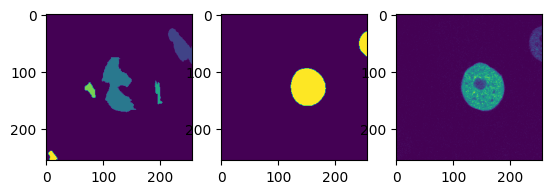

In [258]:
from scipy.ndimage import find_objects, gaussian_filter, generate_binary_structure, label, maximum_filter1d, binary_fill_holes

def get_masks_unet(output, cell_threshold=0, boundary_threshold=0):
    """ create masks using cell probability and cell boundary """
    cells = (output[...,1] - output[...,0])>cell_threshold
    print(cells.shape)
    selem = generate_binary_structure(cells.ndim, connectivity=1)
    print(selem.shape)
    labels, nlabels = label(cells, selem)
    print(labels.shape)
    print(nlabels)

    if output.shape[-1]>10:
        slices = find_objects(labels)
        dists = 10000*np.ones(labels.shape, np.float32)
        mins = np.zeros(labels.shape, np.int32)
        borders = np.logical_and(~(labels>0), output[...,2]>boundary_threshold)
        pad = 10
        for i,slc in enumerate(slices):
            if slc is not None:
                slc_pad = tuple([slice(max(0,sli.start-pad), min(labels.shape[j], sli.stop+pad))
                                    for j,sli in enumerate(slc)])
                msk = (labels[slc_pad] == (i+1)).astype(np.float32)
                msk = 1 - gaussian_filter(msk, 5)
                dists[slc_pad] = np.minimum(dists[slc_pad], msk)
                mins[slc_pad][dists[slc_pad]==msk] = (i+1)
        labels[labels==0] = borders[labels==0] * mins[labels==0]
        
    masks = labels
    shape0 = masks.shape
    _,masks = np.unique(masks, return_inverse=True)
    masks = np.reshape(masks, shape0)
    return masks


#img = torch.from_numpy( np.tile(X_train[0][0:256,0:256], (2,1, 1)) ).unsqueeze(0).to('cuda:0') .float()
img = np.tile(X_train[0][0:256,0:256], (2,1, 1))
shape = img.shape
rescale = np.ones(1)
img = resize_image(img, rsz=rescale[0])

img = torch.from_numpy(img).unsqueeze(0).to('cuda:0') .float()

y, style = cellpose_model.net(img)
y = y.cpu().detach().numpy()[0]
y = y.transpose((1, 2, 0))

masks = get_masks_unet(y, cell_threshold=2, boundary_threshold=0.5)
maski = fill_holes_and_remove_small_masks(masks, min_size=15)


#maski = resize_image(maski.astype(int), shape[-1], shape[-2], interpolation=cv2.INTER_NEAREST)


plt.subplot(1,3,1)
plt.imshow(maski)
plt.subplot(1,3,2)
plt.imshow(y_train_cp[0][0:256,0:256])
plt.subplot(1,3,3)
plt.imshow(X_train[0][0:256,0:256])
plt.show()

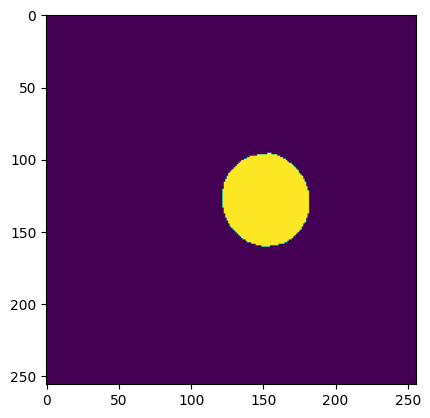

In [262]:
masks, flows, styles = cellpose_model.eval(X_train[0][0:256,0:256], diameter=None, channels=[0,0])

plt.imshow(masks)

(3, 256, 256)


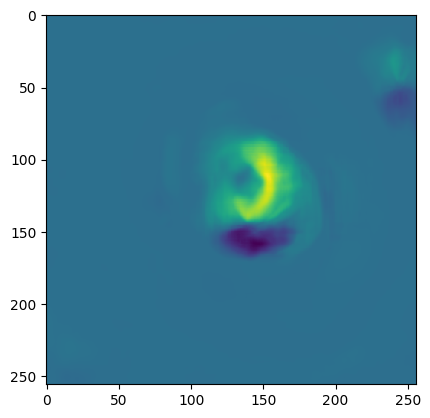

In [128]:
output_net = cellpose_model.net(torch.from_numpy( np.tile(X_train[0][0:256,0:256], (2,1, 1)) ).unsqueeze(0).to('cuda:0') .float())
output_net = output_net[0].cpu().detach().numpy()[0]
print(output_net.shape)
plt.imshow(output_net[0,:,:])

In [108]:
minus = (output[...,1] - output[...,0])
print(minus.shape)

(3, 256)


(256, 256)


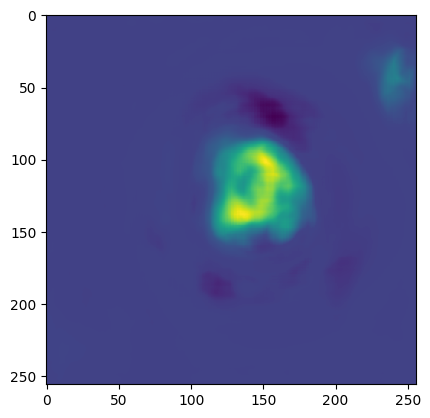

In [94]:
#average output over the 3 channels
output_mean = np.mean(output,axis=0)
print(output_mean.shape)
plt.imshow(output_mean)

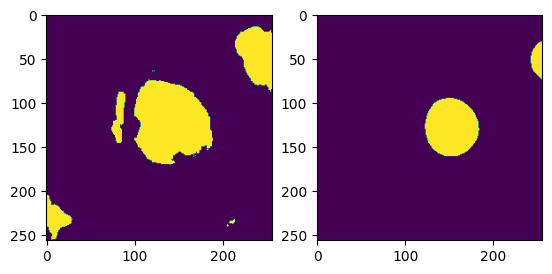

In [101]:
binary = np.where(output_mean>0,1,0)

plt.subplot(1,2,1)
plt.imshow(binary)
plt.subplot(1,2,2)
plt.imshow(y_train_cp[0][0:256,0:256])
plt.show()

In [ ]:
print(outpu)

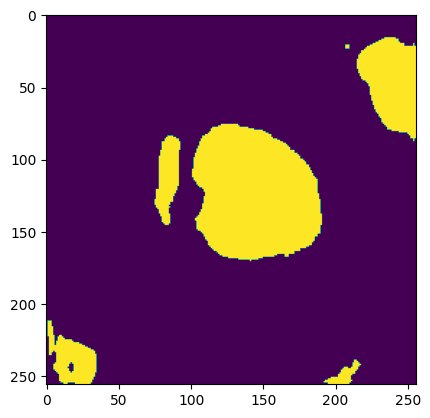

In [86]:
binary = np.where(output[0][0].cpu().detach().numpy()[2,:,:]>0.5,1,0)

plt.imshow(binary)

In [3]:
print(len(X_train))

147


In [4]:
import torchvision
from torchvision import transforms

import torchvision.transforms.functional as TF
import random
    
for i in range(len(X_train)):
    X_train.append(np.rot90(X_train[i],1))
    X_train.append(np.rot90(X_train[i],2))
    X_train.append(np.rot90(X_train[i],3))

    y_train_cp.append(np.rot90(y_train_cp[i],1))
    y_train_cp.append(np.rot90(y_train_cp[i],2))
    y_train_cp.append(np.rot90(y_train_cp[i],3))


In [5]:
print(len(X_train))


588


In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, image, mask):
        self.image = image
        self.mask = mask

    def __len__(self):
        return len(self.mask)

    def __getitem__(self, idx):
        img = self.image[idx]
        label = self.mask[idx]
        return img, label

In [7]:
X_train_torch = [torch.from_numpy(np.array(X_train[i])) for i in range(len(X_train))]
y_train_cp_torch = [torch.from_numpy(np.array(y_train_cp[i])).type(torch.float32) for i in range(len(y_train_cp))]
X_test_torch = [torch.from_numpy(np.array(X_test[i])) for i in range(len(X_test))]
y_test_cp_torch = [torch.from_numpy(np.array(y_test_cp[i])).type(torch.float32) for i in range(len(y_test_cp))]

In [16]:
train_dataset = ImageDataset(X_train_torch, y_train_cp_torch)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = ImageDataset(X_test_torch, y_test_cp_torch)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [14]:
#model
model = UNet()
model = model.to('cuda:0')

#model configurations
#loss_fn = DiceBCELoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [153]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t,r,a,f)

17170956288 12580814848 1219057664 11361757184


In [18]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [142]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t,r,a,f)

17170956288 12580814848 1157193216 11423621632


In [154]:
print(len(X_train))

588


In [23]:
#BCEwithlogitsloss
print('training')
dices_on_GPU = []
for epoch in range(10):
    start_time = time.time()
    dice = train_epoch(model, train_loader, test_loader, loss_fn, torch.sigmoid, optimiser)
    print('epoch: ', epoch, 'dice', dice, 'time: ', time.time()-start_time)
    dices_on_GPU.append(dice)

training
epoch:  0 dice tensor(0.7762, device='cuda:0') time:  31.630845069885254
epoch:  1 dice tensor(0.8890, device='cuda:0') time:  32.03411841392517
epoch:  2 dice tensor(0.8877, device='cuda:0') time:  32.07377648353577
epoch:  3 dice tensor(0.8691, device='cuda:0') time:  32.26577949523926
epoch:  4 dice tensor(0.8780, device='cuda:0') time:  32.11173176765442
epoch:  5 dice tensor(0.8891, device='cuda:0') time:  32.18209934234619
epoch:  6 dice tensor(0.8848, device='cuda:0') time:  32.60564923286438
epoch:  7 dice tensor(0.8894, device='cuda:0') time:  32.96140384674072
epoch:  8 dice tensor(0.8936, device='cuda:0') time:  33.32886290550232
epoch:  9 dice tensor(0.9008, device='cuda:0') time:  32.995445728302


In [156]:
torch.save(model.state_dict(), 'c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\distillation_model_GOWT1_3')

: 

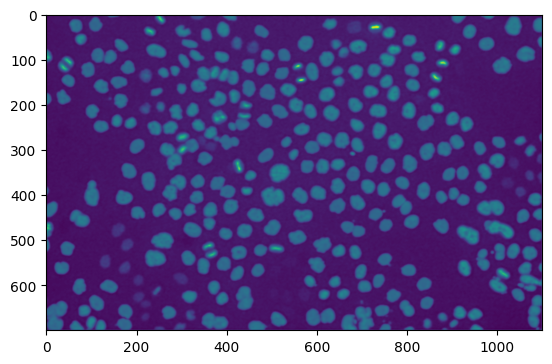

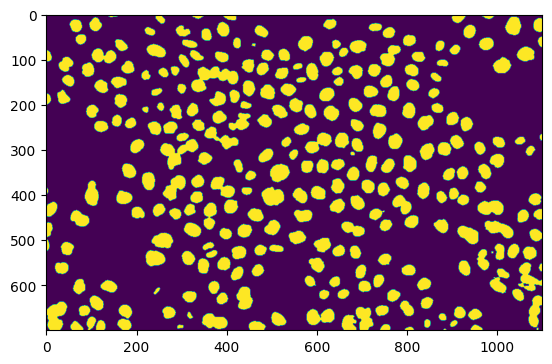

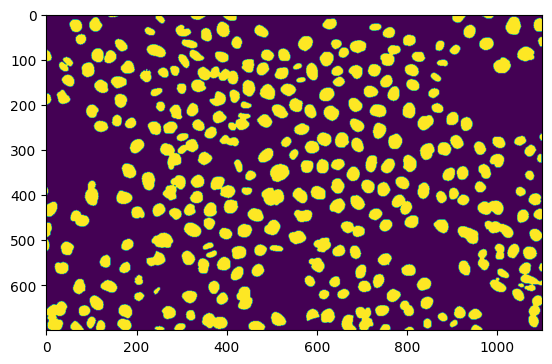

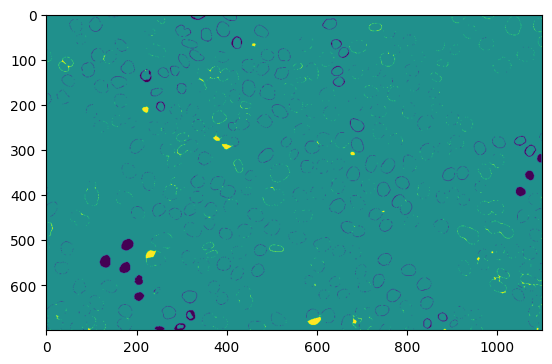

In [106]:
import matplotlib.pyplot as plt

pred = model(X_test_torch[0].unsqueeze(0).unsqueeze(0).to('cuda:0'))

plt.imshow(pred.detach().cpu().numpy().squeeze(0).squeeze(0))
plt.show()

pred = torch.sigmoid(pred)
pred = torch.where(pred>0.5,1.0,0.0)

plt.imshow(pred.detach().cpu().numpy().squeeze(0).squeeze(0))
plt.show()

plt.imshow(y_test_cp_torch[0].detach().cpu().numpy())
plt.show()

plt.imshow(pred.detach().cpu().numpy().squeeze(0).squeeze(0)-y_test_cp_torch[0].detach().cpu().numpy())
plt.show()



In [78]:
print(dices_on_GPU)

[tensor(0.1617, device='cuda:0'), tensor(0.8027, device='cuda:0'), tensor(0.8274, device='cuda:0'), tensor(0.8925, device='cuda:0'), tensor(0.8869, device='cuda:0'), tensor(0.9155, device='cuda:0'), tensor(0.9495, device='cuda:0'), tensor(0.9608, device='cuda:0'), tensor(0.9570, device='cuda:0'), tensor(0.9491, device='cuda:0')]


In [96]:
import cv2
from skimage import measure

def binary_to_instance_mask(binary_mask):
    #We first erode the mask to unconnect touching cell masks
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(binary_mask.astype('uint8'), kernel, iterations=1)

    #We then give a unique number to each cluster
    instances = measure.label(erosion, connectivity=2)

    #We calculate the center of each cluster
    cluster_centers = np.array([np.mean(np.where(instances == i), axis=1) for i in np.unique(instances) if i != 0])
    
    for i in range(len(binary_mask)):
        print(i)

        for j in range(len(binary_mask)):
            if binary_mask[i][j] == 1 and instances[i][j] == 0:
                distances = np.sqrt((cluster_centers[:,0] - i)**2 + (cluster_centers[:,1] - j)**2)
                instances[i][j] = np.unique(instances)[np.argmin(distances)+1]
                
    return instances

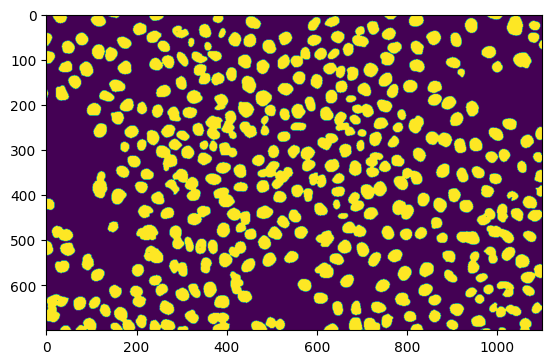

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

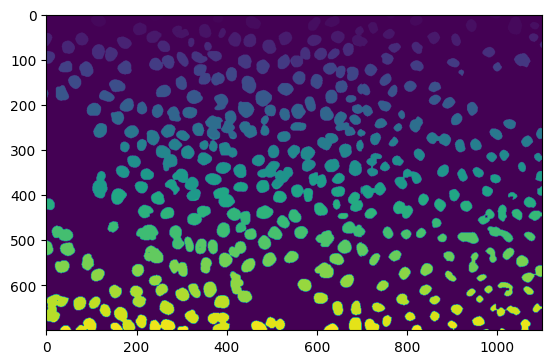

In [99]:
#get some groundtruth mask
import matplotlib.pyplot as plt
plt.imshow(y_train_cp[0])
plt.show()

instances = binary_to_instance_mask(y_train_cp[0])
plt.imshow(instances)
plt.show()

#binarise them

#apply cluster differentiating

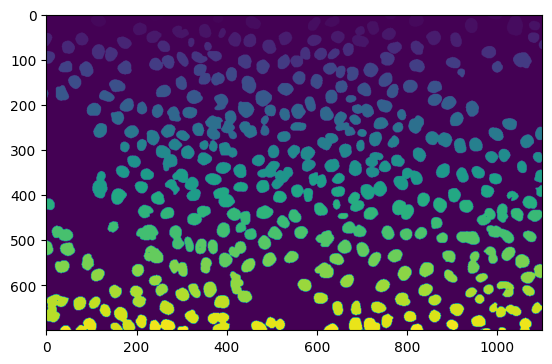

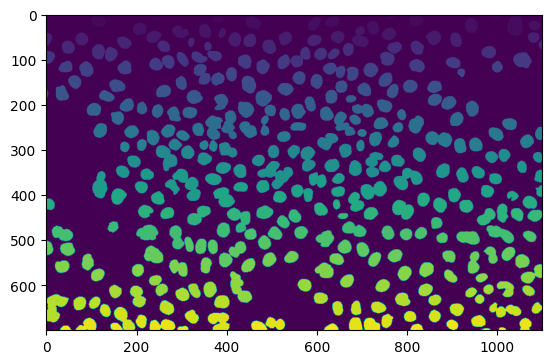

In [106]:
instances_2 = measure.label(y_train_cp[0], connectivity=2)
plt.imshow(instances_2)
plt.show()

instances_2 = measure.label(y_train_cp[0], connectivity=1)
plt.imshow(instances_2)
plt.show()

In [103]:
print(np.unique(instances == instances_2,return_counts=True))

(array([False,  True]), array([207553, 562447], dtype=int64))


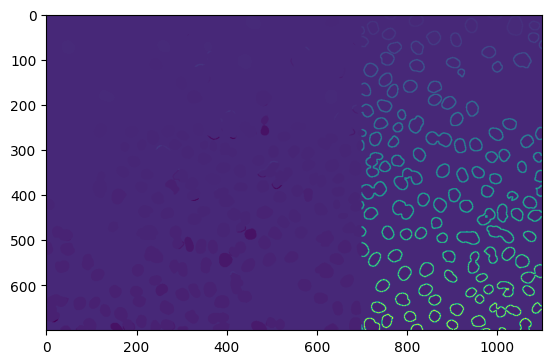

In [105]:
plt.imshow(instances_2-instances)

In [109]:
def get_IoU(predicted_masks,gt_masks):
    intersection_unions = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        union = np.logical_or(predicted_masks[i], gt_masks[i]).sum()
        intersection_unions.append(intersection/union)
    return mean(intersection_unions)

def get_dice(predicted_masks,gt_masks):
    dices = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        dice = (2*intersection)/(predicted_masks[i].sum() + gt_masks[i].sum())
        dices.append(dice)
    return mean(dices)


In [111]:
#import the trained model
model = UNet()
model = model.to('cuda:0')
model.load_state_dict(torch.load('c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\unet_trained_model'))

#get predictions on test_cp
predicted_masks = []
for x in X_test:
    prediction = model(torch.unsqueeze(torch.from_numpy(np.array(x)),0).to('cuda:0').to(torch.float32).unsqueeze(1))
    prediction = torch.sigmoid(prediction)
    prediction = torch.where(prediction>0.5,1.0,0.0)
    prediction = prediction.squeeze(0).squeeze(0).cpu().detach().numpy()
    predicted_masks.append(prediction)

#make predictions on the test_cp and get the IoU and Dice scores
#get IoU and dice coeff
IoU = get_IoU(predicted_masks,y_test_cp)
dice = get_dice(predicted_masks,y_test_cp)
print('IoU: ', IoU)
print('Dice: ', dice)

IoU:  0.9354714736800913
Dice:  0.9666529620616084


In [118]:
preds = model(torch.from_numpy(np.array(X_test)).to('cuda:0').to(torch.float32).unsqueeze(1))

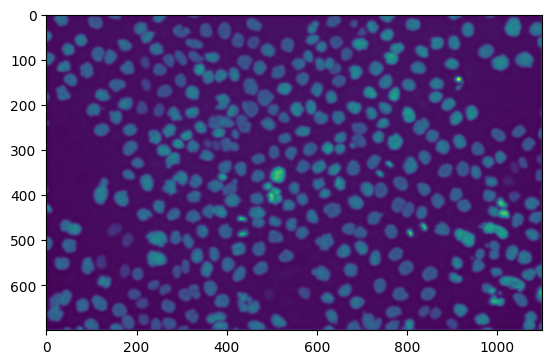

In [122]:
plt.imshow(preds[2].squeeze(0).squeeze(0).cpu().detach().numpy())

In [125]:
print(np.unique(preds[0].squeeze(0).squeeze(0).cpu().detach().numpy()))

[-9.239323 -9.209831 -9.206938 ... 48.46855  48.697002 48.837357]


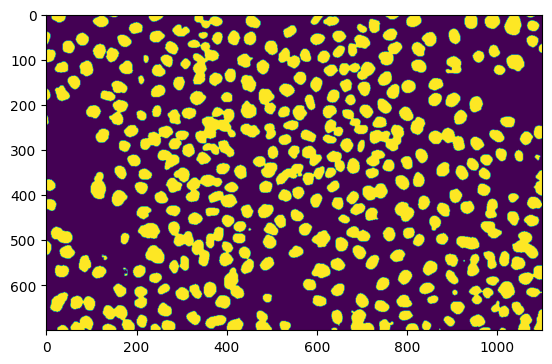

In [115]:
plt.imshow(predicted_masks[3])